In [1]:
# Load model from file
import pickle
 
with open('model.pkl', 'rb') as f:
    model = pickle.load(f)

In [7]:
import nltk
import re
from nltk.stem import WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk import pos_tag

nltk.download('omw-1.4')
nltk.download('wordnet') 
nltk.download('wordnet2022')
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')

lemmatizer = WordNetLemmatizer()
stop_words = list(stopwords.words('english'))

def process_texts(text):

    # Strip and convert text to lower case
    text = text.strip().lower()

    # Remove urls
    text = re.sub(r'http\S+', '', text)
    
    # Remove escape characters
    text = re.sub(r'\@\w+', '', text)

    # Remove emojis
    emoji = re.compile("["
        u"\U0001F600-\U0001F64F"  # emoticons
        u"\U0001F300-\U0001F5FF"  # symbols & pictographs
        u"\U0001F680-\U0001F6FF"  # transport & map symbols
        u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
        u"\U00002500-\U00002BEF"  # chinese char
        u"\U00002702-\U000027B0"
        u"\U000024C2-\U0001F251"
        u"\U0001f926-\U0001f937"
        u"\U00010000-\U0010ffff"
        u"\u2640-\u2642" 
        u"\u2600-\u2B55"
        u"\u200d"
        u"\u23cf"
        u"\u23e9"
        u"\u231a"
        u"\ufe0f"  # dingbats
        u"\u3030"
                      "]+", re.UNICODE)
    text = re.sub(emoji, '', text)

    # Remove html tags 
    text = re.sub(r'<.*?>', '', text)
    
    # Remove new line in string form
    text = re.sub(r'\\n', '', text)

    # Replace brackets with space
    text = re.sub(r'[\]\[\)\(]', ' ', text)
    
    # Remove all characters except alphabets
    text = re.sub(r'[^A-Za-z]' ,' ', text)

    # Replace multiple whitespace with single space
    text = re.sub(r'\s\s+', ' ', text)

    # Tokenize the sentence
    tokens = word_tokenize(text)

    # Remove stop words
    tokens = [t for t in tokens if not t in stop_words]

    # POS tag the words
    pos = pos_tag(tokens)

    # Lemmatize all words
    text = []
    for word, tag in pos:
        wntag = tag[0].lower()
        wntag = wntag if wntag in ['a', 'r', 'n', 'v'] else None
        text.append(lemmatizer.lemmatize(word, wntag) if wntag else word)

    # Remove single letter words
    for w in text:
        if len(w) <= 1:
            text.remove(w)

    return ' '.join(text)

[nltk_data] Downloading package omw-1.4 to /home/brian/nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!
[nltk_data] Downloading package wordnet to /home/brian/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package wordnet2022 to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package wordnet2022 is already up-to-date!
[nltk_data] Downloading package punkt to /home/brian/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/brian/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /home/brian/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [26]:
import pandas as pd

def predict_stress(text):
    predicted_label = model.predict([text])[0] 
    return predicted_label

def predict_stress_reddit(df_reddit):
    df_reddit = df_reddit[['selftext', 'created']]
    df_reddit = df_reddit.dropna()

    df_reddit['created'] = df_reddit['created'].astype(int)
    df_reddit['created_time'] = pd.to_datetime(df_reddit['created'], unit='s')

    # Process texts
    df_reddit['processed_text'] = df_reddit['selftext'].apply(lambda x : process_texts(x))

    # Remove posts that are too short
    df_reddit = df_reddit[df_reddit['processed_text'].apply(lambda x: len(x.split()) >= 10)]

    # Predict stress
    df_reddit['stress'] = df_reddit['processed_text'].apply(lambda x : predict_stress(x))

    return df_reddit

In [27]:
df_sfu = predict_stress_reddit(pd.read_json('datasets/reddit/simonfraser_submissions.zip', lines=True))

df_sfu.sample(10)

,selftext,created,created_time,processed_text,stress
23188,So I am currently undeclared and will finish m...,1680363982,2023-04-01 15:46:22,currently undeclared finish core science cours...,0
24938,So I’m taking Math 100 this upcoming Fall seme...,1692388317,2023-08-18 19:51:57,take math upcoming fall semester want know adv...,0
817,I hear mixed reviews about SFU and it's campus...,1397628210,2014-04-16 06:03:30,hear mixed review sfu campus life hop current ...,0
26692,Is Scott’s 201 class curved or scaled? How doe...,1700703281,2023-11-23 01:34:41,scott class curve scaled end grade class end s...,0
25103,"If anyone has bobby Chan notes for cmpt 272, p...",1693712011,2023-09-03 03:33:31,anyone bobby chan note cmpt please share googl...,0
1085,**1. Grades**\n\nI was put on academic probati...,1414200373,2014-10-25 01:26:13,grade put academic probation langara sfu admis...,0
1510,"Repost from the Megathread, might get more vis...",1435697555,2015-06-30 20:52:35,repost megathread might get visibility hi ever...,0
24494,So I'm trying to enroll in one course but it s...,1689183362,2023-07-12 17:36:02,try enroll one course say unable add class tim...,0
24518,"Hi,\n\nI’m currently a student in Beedie thats...",1689303929,2023-07-14 03:05:29,hi currently student beedie thats intend conce...,1
834,"Hi,\nI'm a prospective student, currently choo...",1398745343,2014-04-29 04:22:23,hi prospective student currently choose sfu bu...,1


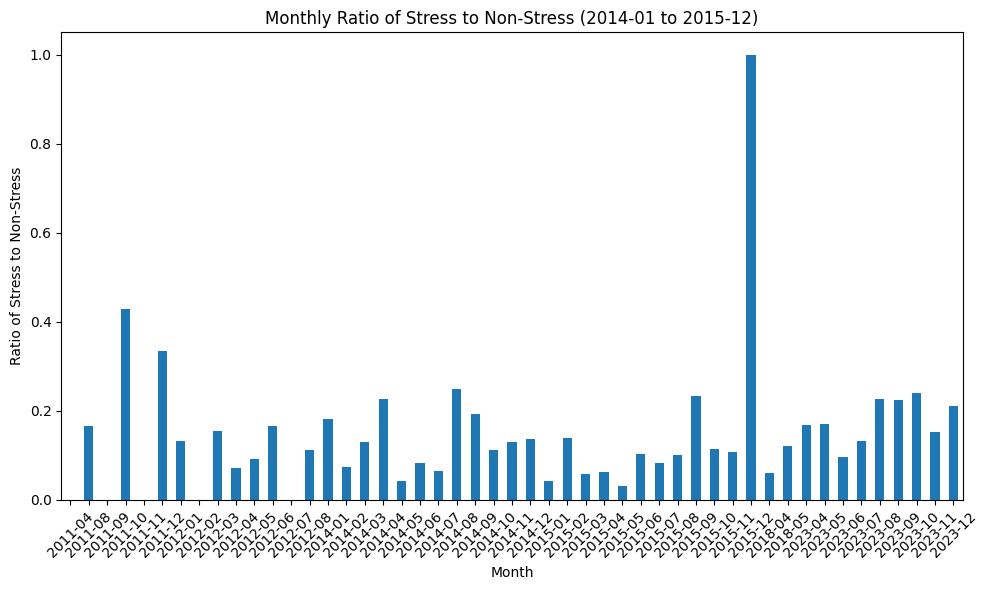

In [28]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

start_date = '2014-01-01'
end_date = '2015-12-31'
filtered_df = df_sfu
#filtered_df = df_sfu[(df_sfu['created_time'] >= start_date) & (df_sfu['created_time'] <= end_date)]

# Group by the month of the 'created' date, then sum the 'stress' values
monthly_data = filtered_df.groupby(filtered_df['created_time'].dt.to_period('M')).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['ratio'] = monthly_data['sum'] / monthly_data['non_stress']

# Reset index to convert PeriodIndex to DateTimeIndex for plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(10, 6))
monthly_data['ratio'].plot(kind='bar', ax=ax)

# Formatting the x-axis
ax.set_xlabel('Month')
ax.set_ylabel('Ratio of Stress to Non-Stress')
ax.set_title('Monthly Ratio of Stress to Non-Stress (2014-01 to 2015-12)')

# Handling x-ticks - Set major formatter
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))

# Adjust x-ticks to display months within the range
ax.set_xticks(range(len(monthly_data.index)))
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

plt.tight_layout()
plt.show()

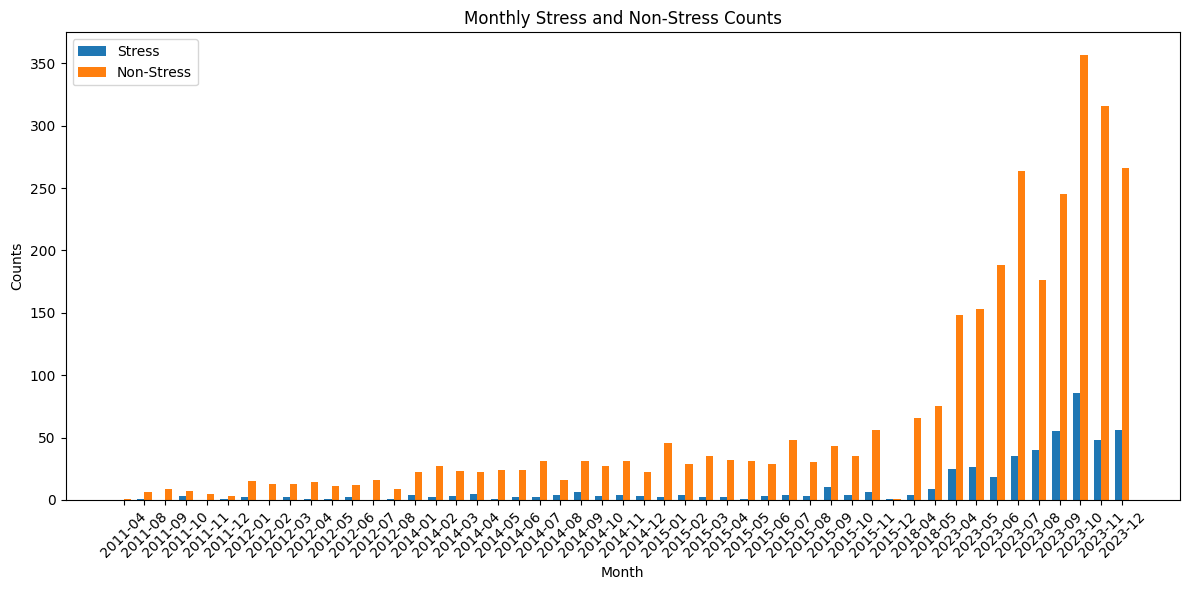

In [29]:
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

# Group by month
monthly_data = df_sfu.groupby(df_sfu['created_time'].dt.to_period('M')).stress.agg(['sum', 'count'])
monthly_data['non_stress'] = monthly_data['count'] - monthly_data['sum']
monthly_data['stress'] = monthly_data['sum']  # Rename for clarity

# Reset index for plotting
monthly_data.index = monthly_data.index.to_timestamp()

# Plotting
fig, ax = plt.subplots(figsize=(12, 6))

# Locations of the groups
ind = range(len(monthly_data))

# Bar width
width = 0.35

# Plotting both stress and non-stress
stress_bars = ax.bar(ind, monthly_data['stress'], width, label='Stress')
non_stress_bars = ax.bar([p + width for p in ind], monthly_data['non_stress'], width, label='Non-Stress')

# Formatting the plot
ax.set_xlabel('Month')
ax.set_ylabel('Counts')
ax.set_title('Monthly Stress and Non-Stress Counts')
ax.set_xticks([p + width / 2 for p in ind])
ax.set_xticklabels([date.strftime('%Y-%m') for date in monthly_data.index], rotation=45)

#ax.set_yscale('log')

ax.legend()

plt.tight_layout()
plt.show()